## 1-) Imports et configuration

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [2]:
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

GPU available: False


### Chemins vers les données

In [3]:
DATA_DIR = "data/raw/cifar10"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

print("Train dir:", TRAIN_DIR)
print("Test dir :", TEST_DIR)
print("Classes dans train:", os.listdir(TRAIN_DIR))

Train dir: data/raw/cifar10\train
Test dir : data/raw/cifar10\test
Classes dans train: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 2-) Chargement des datasets

In [ ]:

# On utilise image_dataset_from_directory avec split train/val
IMG_SIZE = (32, 32)
BATCH_SIZE = 64
SEED = 1337

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Found 50000 files belonging to 10 classes.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 3-) Optimisation du pipeline (cache / prefetch)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare(train_ds, shuffle=True)
val_ds_prep   = prepare(val_ds, shuffle=False)
test_ds_prep  = prepare(test_ds, shuffle=False)

## 4-) Visualisation rapide de quelques images

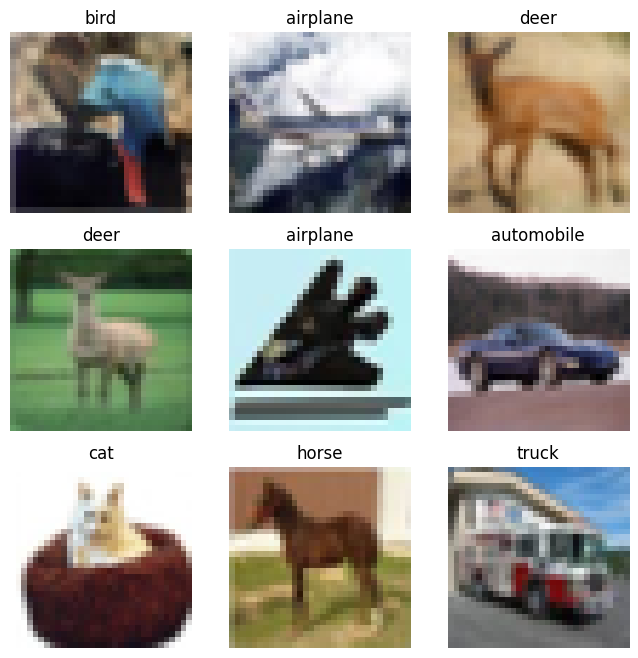

In [9]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 5-) Modèle CNN simple (baseline)

In [10]:
num_classes = len(class_names)

model_cnn = keras.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE + (3,)),
    
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_cnn.summary()

c:\Users\ouldb\Documents\deepvision-cifar10-classifier\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

## 6-) Entrainement

In [11]:
EPOCHS = 20

history_cnn = model_cnn.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS,
)

Epoch 1/20


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.3887 - loss: 1.6641 - val_accuracy: 0.5342 - val_loss: 1.2951
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.5423 - loss: 1.2927 - val_accuracy: 0.5536 - val_loss: 1.2970
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 99s 36ms/step - accuracy: 0.5978 - loss: 1.1462 - val_accuracy: 0.6239 - val_loss: 1.0515
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 96s 33ms/step - accuracy: 0.6342 - loss: 1.0507 - val_accuracy: 0.6331 - val_loss: 1.0190
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - accuracy: 0.6614 - loss: 0.9736 - val_accuracy: 0.6693 - val_loss: 0.9482
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - accuracy: 0.6790 - loss: 0.9214 - val_accuracy: 0.6762 - val_loss: 0.9175
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 68s 23ms/step - accuracy: 0.6974 - loss: 0.8707 - val_accuracy: 0.6701 - val_loss: 0.9580
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accuracy: 0.7124 - loss: 0.82

## 7-) Courbes d’apprentissage (CNN baseline)

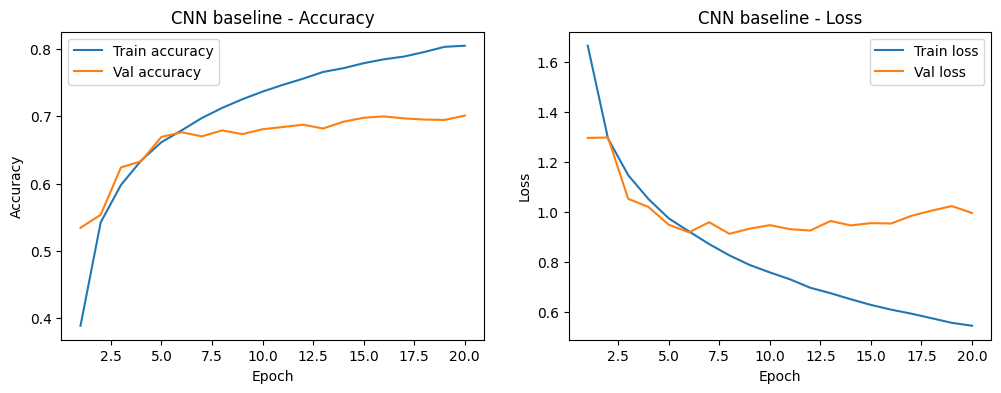

In [12]:
def plot_history(history, title_prefix="CNN baseline"):
    acc      = history.history["accuracy"]
    val_acc  = history.history["val_accuracy"]
    loss     = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs   = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train accuracy")
    plt.plot(epochs, val_acc, label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    plt.show()

plot_history(history_cnn, "CNN baseline")

## 8-) Évaluation détaillée sur le test set

### 8.1 - Accuracy globale sur le test set

In [13]:
test_loss, test_acc = model_cnn.evaluate(test_ds_prep)
print(f"Test loss     : {test_loss:.4f}")
print(f"Test accuracy : {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6961 - loss: 1.0222
Test loss     : 1.0222
Test accuracy : 0.6961


### 8.2 - Classification report et matrice de confusion

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

y_true = []
y_pred = []

for images, labels in test_ds_prep:
    preds = model_cnn.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

              precision    recall  f1-score   support

    airplane       0.66      0.77      0.71      1000
  automobile       0.83      0.81      0.82      1000
        bird       0.66      0.53      0.59      1000
         cat       0.49      0.51      0.50      1000
        deer       0.66      0.65      0.65      1000
         dog       0.61      0.60      0.60      1000
        frog       0.79      0.74      0.76      1000
       horse       0.71      0.77      0.74      1000
        ship       0.78      0.79      0.78      1000
       truck       0.78      0.81      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



array([[768,  19,  41,  19,  15,   6,   5,  16,  79,  32],
       [ 36, 808,   1,   9,   0,   5,   7,   4,  34,  96],
       [ 87,   9, 534,  91,  77,  56,  63,  49,  24,  10],
       [ 32,   9,  51, 506,  73, 177,  57,  51,  25,  19],
       [ 36,   7,  66,  68, 646,  35,  37,  85,  12,   8],
       [ 18,   3,  44, 180,  51, 598,  15,  72,   7,  12],
       [ 12,   5,  46,  83,  48,  32, 740,  12,  12,  10],
       [ 22,   4,  18,  45,  53,  61,   8, 769,   4,  16],
       [104,  33,   7,  17,   9,   7,   4,   4, 786,  29],
       [ 40,  79,   7,  14,   2,   3,   3,  20,  26, 806]])

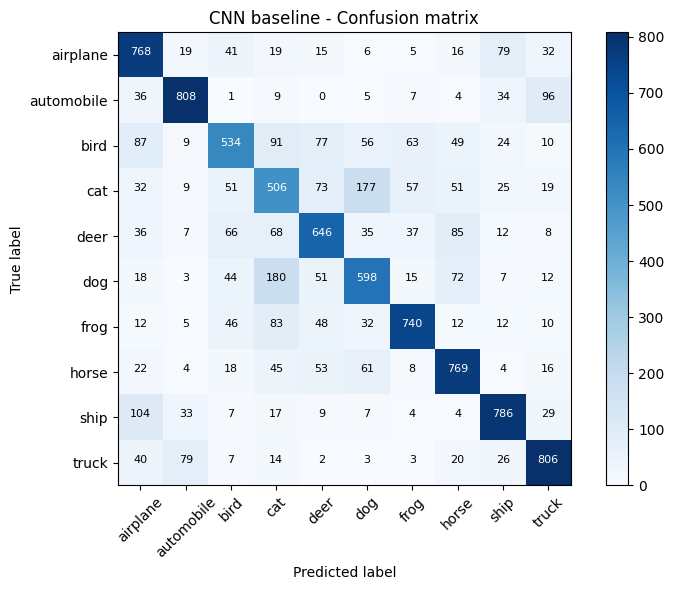

In [15]:
# Grphique latrice de confusion avec matplotlib
def plot_confusion_matrix(cm, class_names, title="CNN baseline - Confusion matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names)

## 9-) Transfert Learning (Modèle avancé)

#### On va utiliser EfficientNetB0, un modèle léger, stable et performant pour CIFAR-10

### 9.1 - Chargement du backbone EfficientNetB0

In [4]:
IMG_SIZE = (224, 224)      # on garde comme avant pour l'instant
BATCH_SIZE = 16            # NOUVELLE VALEUR
SEED = 1337

In [1]:
train_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

NameError: name 'tf' is not defined

In [3]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

IMG_SIZE = (160, 160)  # EfficientNet travaille en 224x224
BATCH_SIZE = 16
SEED = 1337

train_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds_tl = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

NameError: name 'tf' is not defined

### 9.2 - Pipeline optimisé

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_tl = prepare(train_ds_tl, shuffle=True)
val_tl = prepare(val_ds_tl)
test_tl = prepare(test_ds_tl)

### 9.3 - Chargement EfficientNetB0 pré-entraîné

In [21]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False  # On gèle les poids

### 9.4 - Construction du modèle complet

In [23]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = layers.Rescaling(1./255)(inputs)

# Data augmentation moderne
data_aug = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])
x = data_aug(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_tl = models.Model(inputs, outputs)

### 9.5 - Compilation

In [24]:
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Réduction de la charge mémoire

In [1]:
# Réduire le BATCH_SIZE
BATCH_SIZE = 16

### 9.6 - Entraînement (phase 1 : backbone gelé)

In [2]:
EPOCHS = 10

history_tl = model_tl.fit(
    train_tl,
    validation_data=val_tl,
    epochs=EPOCHS
)

NameError: name 'model_tl' is not defined